In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout

# ARIMA with exogenous variables

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3286
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -7215.519
Date:                Tue, 21 May 2024   AIC                          14435.037
Time:                        13:55:21   BIC                          14447.231
Sample:                    01-02-2010   HQIC                         14439.403
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9719      0.004   -227.840      0.000      -0.980      -0.964
sigma2         4.7316      0.106     44.692      0.000       4.524       4.939
Ljung-Box (L1) (Q):                   0.61   Jarque-

/Users/gabrielazemencikova/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gabrielazemencikova/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gabrielazemencikova/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gabrielazemencikova/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 events   No. Observations:                 3286
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -7196.886
Date:                Tue, 21 May 2024   AIC                          14413.773
Time:                        13:55:25   BIC                          14474.744
Sample:                    01-02-2010   HQIC                         14435.603
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
doy           -0.0002      0.000     -0.531      0.595      -0.001       0.001
max_temp      -0.0696      0.012     -5.818      0.000      -0.093      -0.046
min_hum       -0.0061      0.003     -2.031      0.0

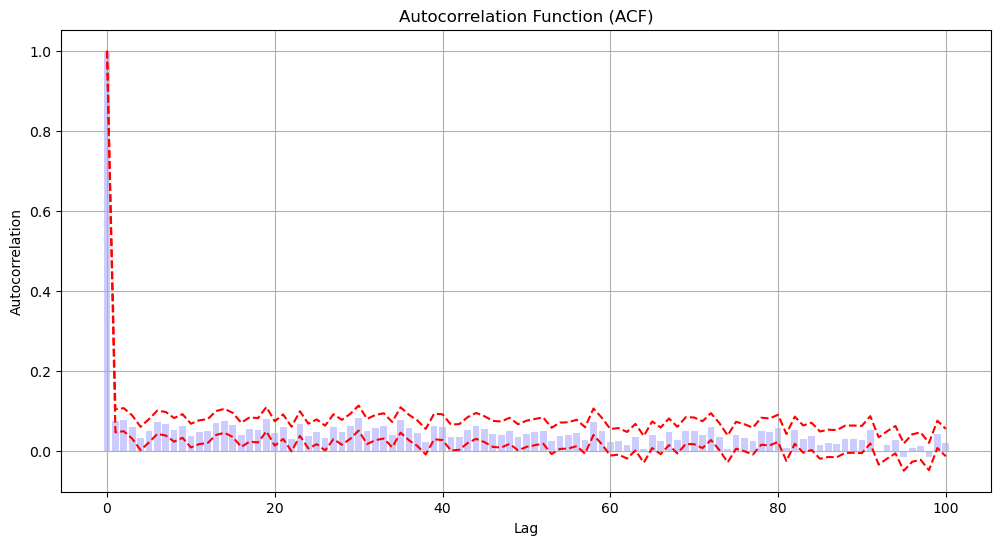

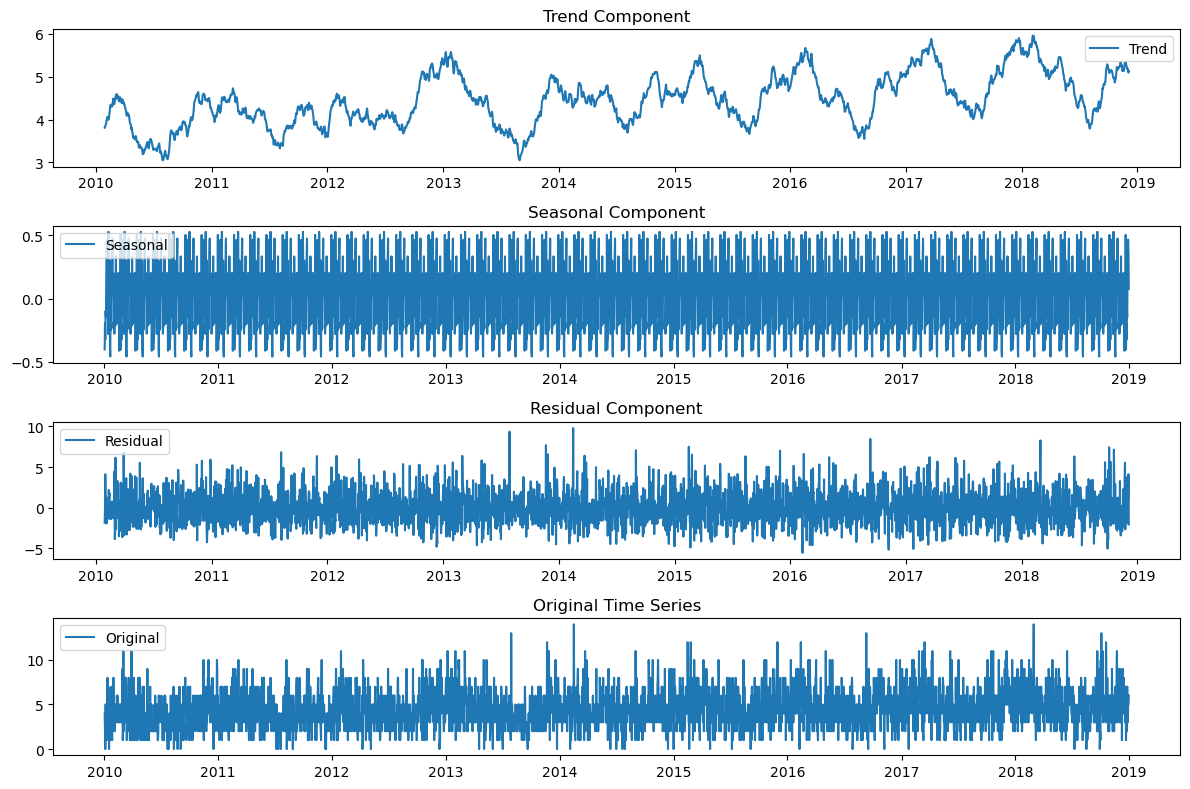

/var/folders/3s/sgsxmx5n0nv1mqxxx0w71rn40000gn/T/ipykernel_30912/3509351067.py:81: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  results.fittedvalues[0] = results.fittedvalues.mean()  # Avoiding NaNs for plotting


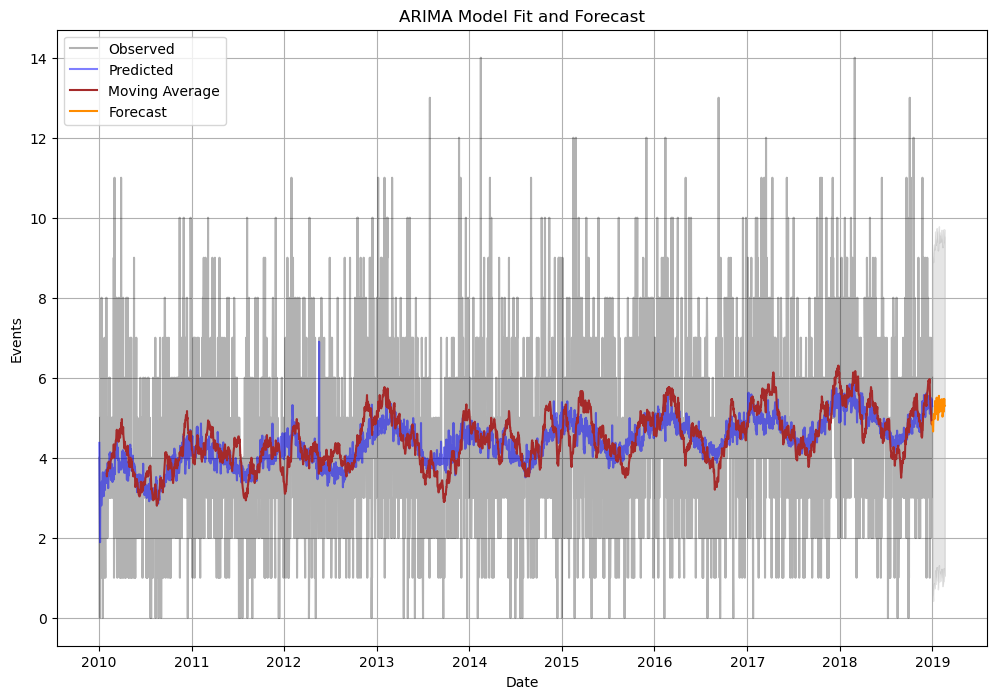

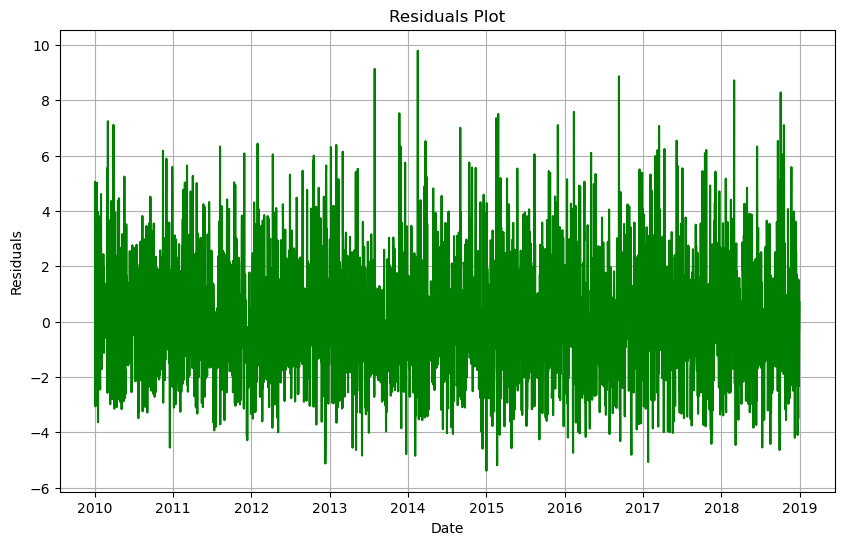

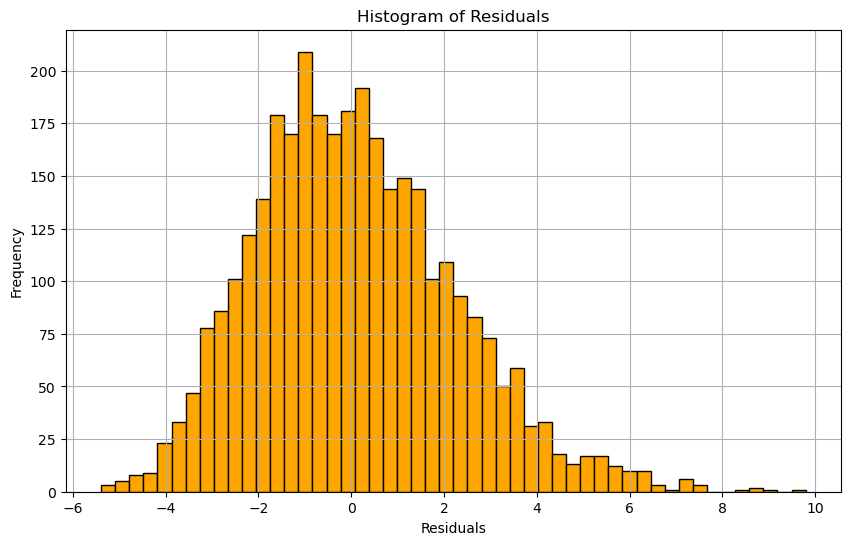

Box-Ljung Test p-values: 1      0.263809
2      0.270390
3      0.453852
4      0.202735
5      0.275096
         ...   
100    0.625280
101    0.632664
102    0.659056
103    0.684604
104    0.685812
Name: lb_pvalue, Length: 104, dtype: float64
Box-Ljung Test statistics: 1       1.248660
2       2.615783
3       2.620817
4       5.952358
5       6.333624
         ...    
100    94.902752
101    95.611994
102    95.613476
103    95.615152
104    96.534907
Name: lb_stat, Length: 104, dtype: float64
Mean Absolute Error (MAE): 1.715592197469838
Mean Squared Error (MSE): 4.688744005726937
Root Mean Squared Error (RMSE): 2.165350781219278
Mean Absolute Percentage Error (MAPE): 265579807877994.62
Akaike Information Criterion (AIC): 14413.772798808968
Bayesian Information Criterion (BIC): 14474.744018118156


In [12]:
# Load the data
df_f = pd.read_csv("entire_data.csv")
df_f = df_f.loc[df_f.at_code == "AT01"]
df_f['date'] = pd.to_datetime(df_f['date'])
df_f = df_f.set_index('date')

# integer encode direction
encoder = LabelEncoder()
df_f['dow'] = encoder.fit_transform(df_f['dow'])
df_f['season'] = encoder.fit_transform(df_f['season'])

# Calculate the moving average
window_size = 30  # 30-days moving average
moving_average = df_f['events'].rolling(window=window_size).mean()

# Define the target variable and features
Y = df_f['events']
# X = df_f[['doy', 'max_temp', 'min_hum', 'max_PM10', 'max_O3', 'is_holiday']] #'dow', 'season'
X = df_f[['doy', 'max_temp', 'min_hum', 'max_PM10', 'max_O3', 'is_holiday', 'dow', 'season']]

# Fit auto ARIMA model
auto_model = pm.auto_arima(Y, seasonal=True, m=6)  # Assuming monthly seasonality
# Print the summary of the model
print(auto_model.summary())

# Fit ARIMA model
order = (0, 1, 1)
model = sm.tsa.ARIMA(Y, order=order, exog=X)
results = model.fit()
print(results.summary())

# Plot ACF
lags = 100
acf_values, confint = acf(Y, nlags=lags, alpha=0.1)

plt.figure(figsize=(12, 6))
plt.bar(range(lags + 1), acf_values, color='blue', alpha=0.2)
plt.plot(range(lags + 1), confint[:, 0], linestyle='--', color='red')
plt.plot(range(lags + 1), confint[:, 1], linestyle='--', color='red')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

# Decompose the time series
decomposition = seasonal_decompose(Y, model='additive', period=52)  # Assuming weekly seasonality

# Plot the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.trend, label='Trend')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.resid, label='Residual')
plt.title('Residual Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(Y, label='Original')
plt.title('Original Time Series')
plt.legend()

plt.tight_layout()
plt.show()

# Forecast future values
n_steps = 50
forecast = results.get_forecast(steps=n_steps, exog=X.iloc[-n_steps:])
forecast_index = pd.date_range(start=Y.index[-1], periods=n_steps + 1)

# Plot observed vs. predicted values and forecast
results.fittedvalues[0] = results.fittedvalues.mean()  # Avoiding NaNs for plotting
plt.figure(figsize=(12, 8))

# Plot observed vs. predicted values
plt.plot(df_f.index, Y, color='black', alpha = 0.3, label='Observed')
plt.plot(df_f.index, results.fittedvalues, color='blue', alpha = 0.5, label='Predicted')
plt.plot(moving_average.index, moving_average, color='brown', alpha = 1, label='Moving Average')

# Plot forecasted values
plt.plot(forecast_index[1::], forecast.predicted_mean, color='darkorange', label='Forecast')
plt.fill_between(forecast_index[1::], forecast.conf_int()['lower events'], forecast.conf_int()['upper events'], color='k', alpha=0.1)

plt.title('ARIMA Model Fit and Forecast')
plt.xlabel('Date')
plt.ylabel('Events')
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals
residuals = results.resid
plt.figure(figsize=(10, 6))
plt.plot(df_f.index, residuals, color='green')
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='orange', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Ljung-Box test
result = acorr_ljungbox(residuals, period=52)
print("Box-Ljung Test p-values:", result.lb_pvalue)
print("Box-Ljung Test statistics:", result.lb_stat)

# Calculate and print additional metrics
mae = np.mean(np.abs(residuals))
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(Y, results.fittedvalues)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Akaike Information Criterion (AIC):", results.aic)
print("Bayesian Information Criterion (BIC):", results.bic)


# SARIMAX with exogenous variables

/Users/gabrielazemencikova/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gabrielazemencikova/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44007D+00    |proj g|=  1.36493D-01


 This problem is unconstrained.



At iterate    5    f=  2.36958D+00    |proj g|=  7.24628D-01

At iterate   10    f=  2.33882D+00    |proj g|=  3.71817D-01

At iterate   15    f=  2.27414D+00    |proj g|=  1.00661D-01

At iterate   20    f=  2.26039D+00    |proj g|=  2.84271D-01

At iterate   25    f=  2.25411D+00    |proj g|=  4.27614D-01

At iterate   30    f=  2.23132D+00    |proj g|=  7.94959D-01

At iterate   35    f=  2.21815D+00    |proj g|=  5.39939D-01

At iterate   40    f=  2.21051D+00    |proj g|=  2.08303D-01

At iterate   45    f=  2.20532D+00    |proj g|=  4.37932D-01


/Users/gabrielazemencikova/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.20166D+00    |proj g|=  5.00462D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     55      1     0     0   5.005D-02   2.202D+00
  F =   2.2016600897581924     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                     
Dep. Variable:                            events   No. Observations:                 3286
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood               -7234.655
Date:                           Tue, 21 May 2024   AIC                          14495.310
T

<Figure size 1200x600 with 0 Axes>

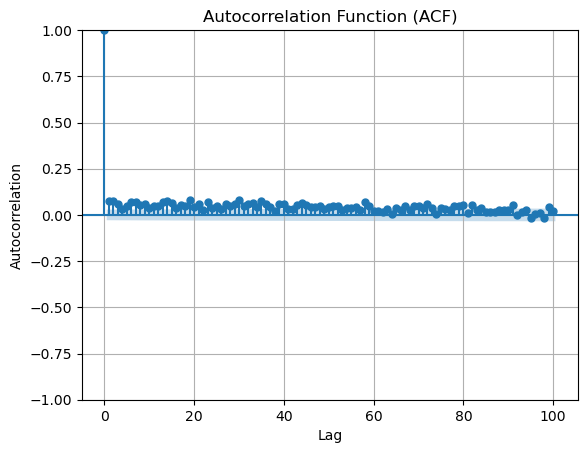

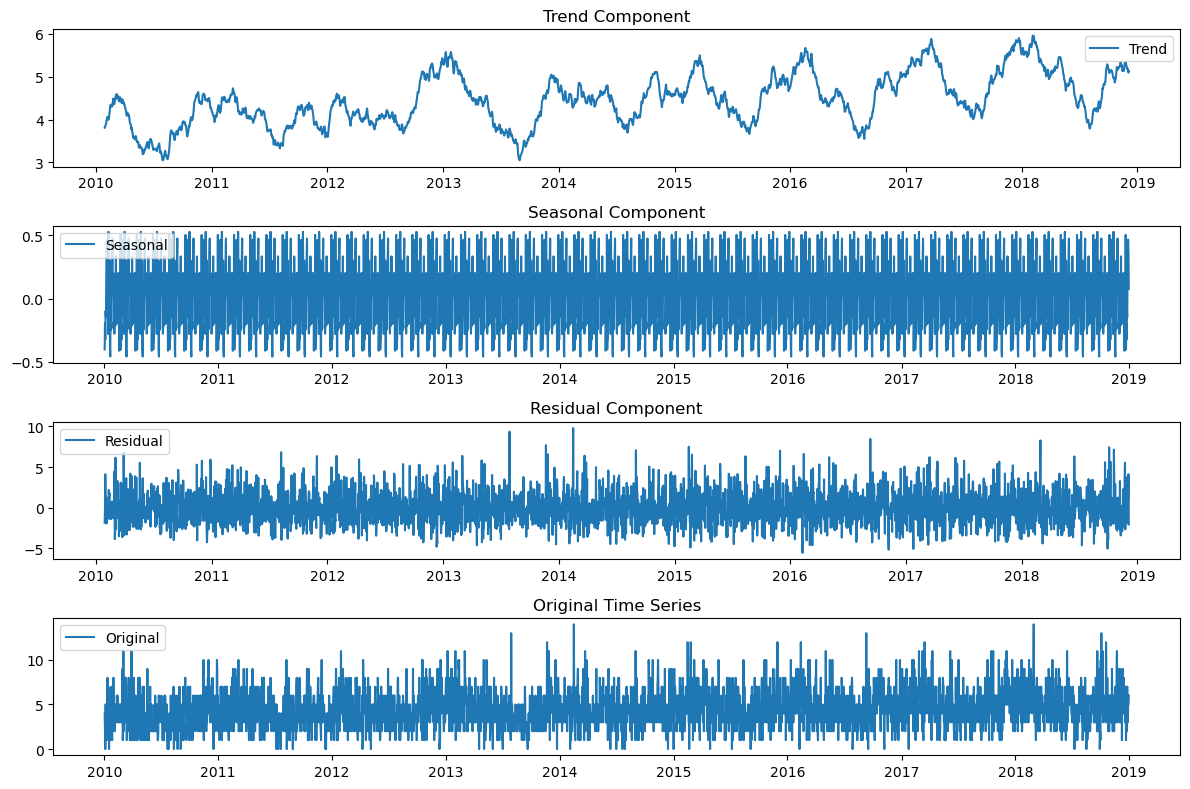

/var/folders/3s/sgsxmx5n0nv1mqxxx0w71rn40000gn/T/ipykernel_30912/4077253128.py:58: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  results.fittedvalues[0] = results.fittedvalues.mean()  # Avoiding NaNs for plotting


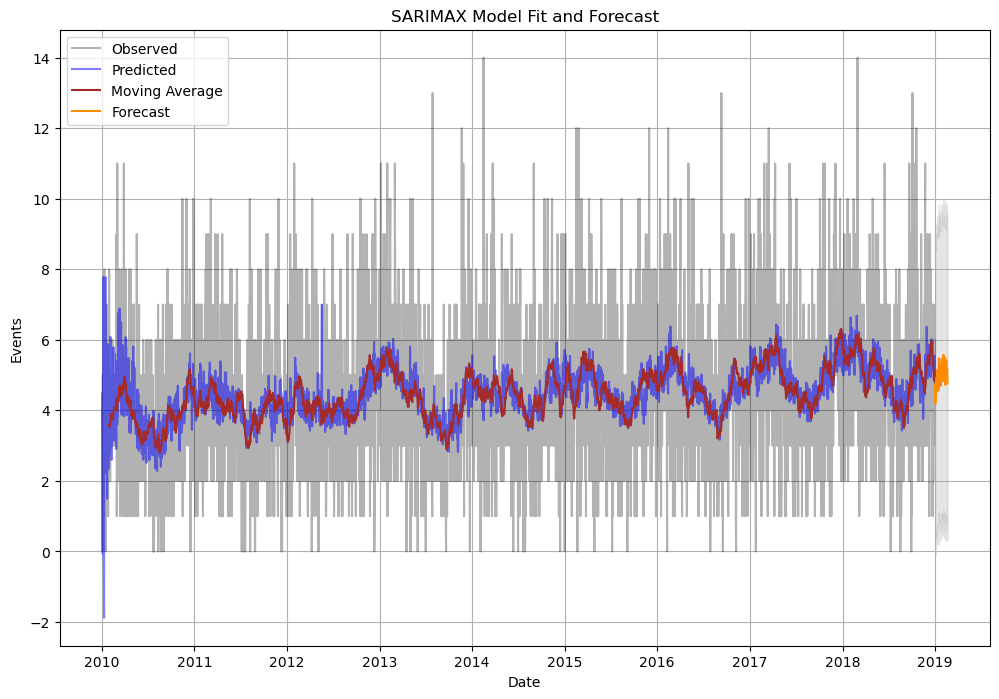

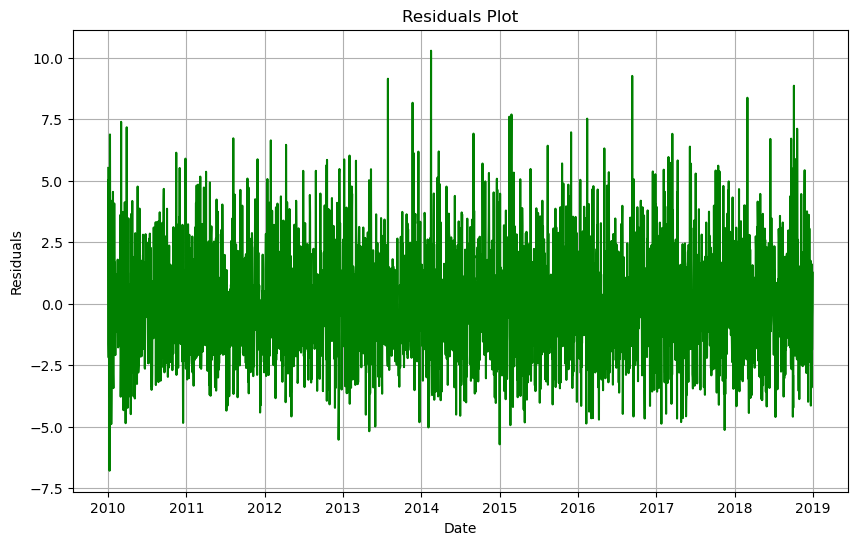

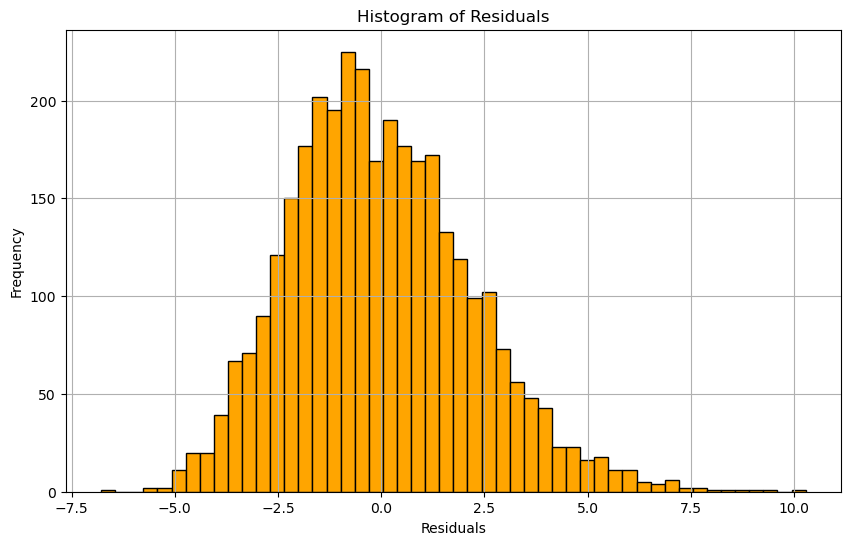

Box-Ljung Test p-values: 1      0.826284
2      0.592479
3      0.757529
4      0.190578
5      0.233987
         ...   
100    0.284220
101    0.299267
102    0.323797
103    0.348516
104    0.365327
Name: lb_pvalue, Length: 104, dtype: float64
Box-Ljung Test statistics: 1        0.048167
2        1.046880
3        1.181149
4        6.117024
5        6.824958
          ...    
100    107.586918
101    107.974217
102    107.977939
103    108.002374
104    108.359716
Name: lb_stat, Length: 104, dtype: float64
Mean Absolute Error (MAE): 1.7561039729920416
Mean Squared Error (MSE): 4.86707443202209
Root Mean Squared Error (RMSE): 2.206144698795183
Mean Absolute Percentage Error (MAPE): 269994785845414.2
Akaike Information Criterion (AIC): 14495.31010989084
Bayesian Information Criterion (BIC): 14574.54892898982


In [13]:
# Define the target variable and features
Y = df_f['events']
X = df_f[['doy', 'max_temp', 'min_hum', 'max_PM10', 'max_O3', 'is_holiday', 'dow', 'season']]

# Fit SARIMAX model
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 6)  # Assuming seasonality of 6 months
model = SARIMAX(Y, exog=X, order=order, seasonal_order=seasonal_order)
results = model.fit()

# Print model summary
print(results.summary())

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(Y, lags=100, alpha=0.1)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()


# Decompose the time series
decomposition = seasonal_decompose(Y, model='additive', period=52)  # Assuming weekly seasonality

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(decomposition.trend, label='Trend')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.resid, label='Residual')
plt.title('Residual Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(Y, label='Original')
plt.title('Original Time Series')
plt.legend()

plt.tight_layout()
plt.show()

# Forecast future values
n_steps = 50
forecast = results.get_forecast(steps=n_steps, exog=X.iloc[-n_steps:])
forecast_index = pd.date_range(start=Y.index[-1], periods=n_steps + 1)

# Plot observed vs. predicted values and forecast
results.fittedvalues[0] = results.fittedvalues.mean()  # Avoiding NaNs for plotting
plt.figure(figsize=(12, 8))

# Plot observed vs. predicted values 
plt.plot(df_f.index, Y, color='black', alpha=0.3, label='Observed')
plt.plot(df_f.index, results.fittedvalues, color='blue', alpha=0.5, label='Predicted')
plt.plot(moving_average.index, moving_average, color='brown', label='Moving Average')

# Plot forecasted values 
plt.plot(forecast_index[1::], forecast.predicted_mean, color='darkorange', label='Forecast')
plt.fill_between(forecast_index[1::], forecast.conf_int()['lower events'], forecast.conf_int()['upper events'], color='k', alpha=0.1)

plt.title('SARIMAX Model Fit and Forecast')
plt.xlabel('Date')
plt.ylabel('Events')
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals
residuals = results.resid
plt.figure(figsize=(10, 6))
plt.plot(df_f.index, residuals, color='green')
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='orange', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Ljung-Box test
result = acorr_ljungbox(residuals, period=52)
print("Box-Ljung Test p-values:", result.lb_pvalue)
print("Box-Ljung Test statistics:", result.lb_stat)

# Calculate and print additional metrics
mae = np.mean(np.abs(residuals))
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(Y, results.fittedvalues)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Akaike Information Criterion (AIC):", results.aic)
print("Bayesian Information Criterion (BIC):", results.bic)

# RSS Neural Network - LSTM

Epoch 1/100
93/93 [==============================] - 3s 13ms/step - loss: 0.0277
Epoch 2/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0248
Epoch 3/100
93/93 [==============================] - 1s 12ms/step - loss: 0.0248
Epoch 4/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0250
Epoch 5/100
93/93 [==============================] - 1s 12ms/step - loss: 0.0244
Epoch 6/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0245
Epoch 7/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0243
Epoch 8/100
93/93 [==============================] - 1s 12ms/step - loss: 0.0243
Epoch 9/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0242
Epoch 10/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0243
Epoch 11/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0243
Epoch 12/100
93/93 [==============================] - 1s 14ms/step - loss: 0.0243
Epoch 13/100
93/93 [=====

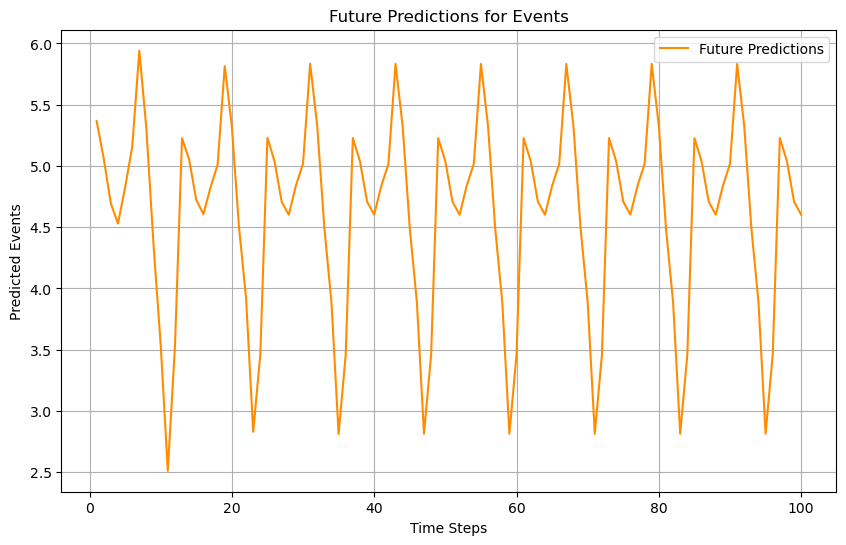

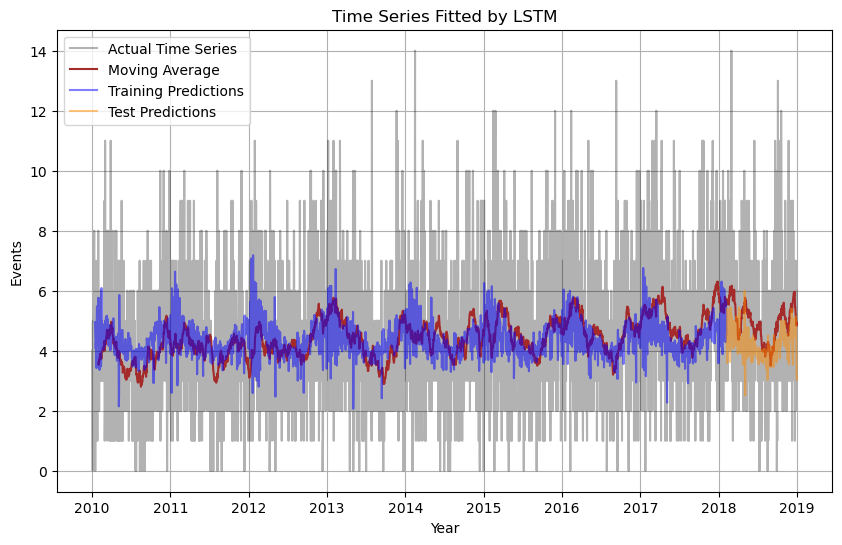

In [14]:
data = df_f[['events', 'dow', 'doy', 'season', 'max_temp', 'min_hum', 'max_PM10', 'max_O3', 'is_holiday']]

# Separate the features and the target
features = data[['max_temp', 'min_hum', 'max_PM10', 'max_O3', 'is_holiday', 'doy', 'dow', 'season']]
target = data['events'].values.reshape(-1, 1)

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Scale the target separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target)

# Function to create sequences
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(scaled_features, scaled_target, seq_length)

train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build the model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Add a dropout layer with a dropout rate of 0.2
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = target_scaler.inverse_transform(train_predict)
y_train = target_scaler.inverse_transform(y_train)
test_predict = target_scaler.inverse_transform(test_predict)
y_test = target_scaler.inverse_transform(y_test)

# Evaluate the model
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))

# Log-likelihood, AIC, and BIC calculations
def calculate_metrics(y_true, y_pred, num_params):
    n = len(y_true)
    resid = y_true - y_pred
    sigma2 = np.var(resid)
    log_likelihood = -n/2 * (np.log(2 * np.pi * sigma2) + 1)
    
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(n) - 2 * log_likelihood
    
    return log_likelihood, aic, bic

num_params = sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
log_likelihood_train, aic_train, bic_train = calculate_metrics(y_train, train_predict, num_params)
log_likelihood_test, aic_test, bic_test = calculate_metrics(y_test, test_predict, num_params)

print(f'RMSE train: {train_score}')
print(f'RMSE test: {test_score}')
print(f'Log-Likelihood train: {log_likelihood_train}')
print(f'Log-Likelihood test: {log_likelihood_test}')
print(f'AIC train: {aic_train}')
print(f'AIC test: {aic_test}')
print(f'BIC train: {bic_train}')
print(f'BIC test: {bic_test}')


# Plot future predictions
future_data = scaled_features[-seq_length:].reshape(1, seq_length, scaled_features.shape[1])
future_predictions = []

# Predict 50 future points
for _ in range(100):
    prediction = model.predict(future_data)[0, 0]
    future_predictions.append(prediction)
    
    # Roll the future data and add the new prediction
    future_data = np.roll(future_data, -1, axis=1)
    future_data[0, -1, 0] = prediction  # Assuming 'events' is the first feature

# Inverse transform the future predictions
future_predictions = target_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the future predictions
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), future_predictions, label='Future Predictions', color='darkorange')
plt.xlabel('Time Steps')
plt.ylabel('Predicted Events')
plt.title('Future Predictions for Events')
plt.legend()
plt.grid(True)
plt.show()
# Plot actual data and predictions
# Extract years from the index
years = data.index

# Inverse transform the actual data for plotting
actual_data = np.hstack((target_scaler.inverse_transform(scaled_target), scaler.inverse_transform(scaled_features)))

# Create years for train and test predictions
train_years = years[seq_length:seq_length + train_size]
test_years = years[seq_length + train_size:seq_length + train_size + test_size]

# Plot the actual data and predictions
plt.figure(figsize=(10, 6))
plt.plot(years, actual_data[:, 0], label='Actual Time Series', color='black', alpha = 0.3)  # Assuming 'events' is the first column
plt.plot(moving_average.index, moving_average, color='brown', label='Moving Average') #Moving Average
# Plot training predictions
plt.plot(train_years, train_predict, label='Training Predictions', color='blue', alpha = 0.5)
# Plot test predictions
plt.plot(test_years, test_predict, label='Test Predictions', color='darkorange', alpha = 0.5)

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Events')
plt.title('Time Series Fitted by LSTM')
plt.legend()
plt.grid(True)
plt.show()

Data without dropout rate wiuthout  'dow', 'season' variables: 

RMSE train: 2.1374522239246203

RMSE test: 2.4087440788631085

Log-Likelihood train: -6416.716424089286

Log-Likelihood test: -742.6410989008774

AIC train: 419435.43284817855

AIC test: 408087.28219780175

BIC train: 1636843.2123264652

BIC test: 1179210.7417959068

Data with dropout rate:

RMSE train: 2.14689918056825

RMSE test: 2.4143645007013776

Log-Likelihood train: -6429.024909369744

Log-Likelihood test: -739.7039858448597

AIC train: 419460.04981873947

AIC test: 408081.4079716897

BIC train: 1636867.8292970262

BIC test: 1179204.8675697946